# Report: Train delays and weather correlation in germany

## 1. Project Idea

Every day, 7.3 milion people in Germany rely on DB trains [^1], which is about every 10th person in Germany. It is rare to find someone who hasn't experienced any issues with DB train. Personally, every time I take the train to get somewhere, I experience delays, missed connections, or even cancellations. This has led me to the question of the underlying causes. I have the feeling that there may be an association between heavy rain or thunderstorms and an increase in train delays. This observation has led to look into a possible correlation between bad weather conditions and train delays.

Uncovering the reasons behind these delays would be of great benefit to the 7.3 million daily passengers who rely on DB trains. With this knowledge, people can plan their trips more efficiently. If people know that there will be bad weather on the day they want to travel, they can plan extra time for connecting trains or look for alternative transportations. Germans, known for their need for planning and punctuality, would greatly benefit from being aware of such a correlation.


While it may be unrealistic to find a single cause of train delays, it would still be useful to draw a connection between train delays and rainy weather. Therefore, the question that the following report attempts to answer is: 

**When investigating DB train delays, is there a correlation between more trains running late or more minutes of delay and rainy weather?**

[^1]:https://www.germany.travel/de/trade/global-trade-corner/deutsche-bahn-ag-db.html

## 2. Data sources und Data pipeline 

To collect the necessary data for this project, different APIs and files were used.
Mobilithek provides links to various DB APIs for train information, including the Timetable API [^2]. This API offers timetable information containing planned and changed timetables for long-distance trains [^2]. The data is offered by DB Station&Service AG and is made available under the Creative Commons Attribution 4.0 International (CC BY 4.0) license [^3]. An overview of the API can be found on the DB API Marketplace [^4].

<img src="timetable_api.png" alt="timetable api" title="DB timetable API" width="200">

The desired data is collected using the Timetables API Version 1.0.213, utilizing the endpoints /fchg to get the current full changes of the timetable of a specific station and the endpoint /station to obtain all stations in germany.

Furthermore, geographical data, such as longitude and latitude of the train station,has to be collected separately from the Station Data API Version 2.7.423 and the endpoint /stations.

<img src="meteostat.png" alt="meteostat" title="Meteostat" width="200">

Weather data was collected from Meteostat Developers [^5], who offers historical weather and climate data also provided under the CC BY 4.0 license. The endpoint /station was used to obtain all weather stations and the endpoint /hourly to get the weather data for the desired stations.

The data pipeline includes some dependencies to manage data loading efficiently and prevent unnecessary slowdowns by getting unnessecary data. The key steps in the pipeline are getting all main train stations in germany, retrieving matching timetables and geo data. Then all weather stations in germany are obtained and matched with the train station, to collect weather data solely for the desired stations.

Data Sources: [Meteostat](https://meteostat.net/en/) and [DB Station&Service AG](https://www.bahnhof.de/)


[^2]: https://mobilithek.info/offers/-3916716856299319220
[^3]: https://creativecommons.org/licenses/by/4.0/
[^4]: https://developers.deutschebahn.com/db-api-marketplace/apis/product/timetables/api/26494#/Timetables_10213/overview 
[^5]: https://dev.meteostat.net/


## 3. Main Problems and Mitigations

### 3.1 Train stations
Given the big number of train stations in germany (17081 to be exact, given by the API), it was necessary to filter the data for the main stations in germany. To simplify the task only train station with the addition "Hbf" where obtained.  

### 3.2 Timetables
The main problem of the API was that there is no historical data on train delays available. To still obtain some data to work with, I set up a cron job to run the pipeline every hour for the past weeks. However, this approach resulted in duplicate entries for trains. To address this, I kept only the most recent update of the timetable for each train.

The timetables obtained from the API come in a weird XML format. To still extract the desired information, I filtered for train departures and retrieved the planned and changed times, allowing the calculation of delays. I considered a train delayed if it had a delay of more than 5 minutes.

### 3.3 Weather stations
Obtaining weather data for all available weather stations was not possible due to the large amount of data. To mitigate this, I matched the train stations to the nearest weather stations using a nearest-neighbor approach and obtained weather data solely for the desired weather stations. Furthermore, I restricted the data to the year 2023.

Unfortunately, there was an unhappy coincidence in the past weeks because there was very little rain. The limited timeframe and the limited rainy days makes it challenging to make out a significant correlation. 

## 4. Answer Data Science Question
### Install dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Load data
The data was preprocessed in an earlier stage, and now the final datasets are being loaded. The timetables dataset includes the eva number and station name, coordinates and the date. The dates were transformed into one-hour increments, and for each hour, the number of trains with delays and the total sum of delayed minutes were calculated and added.

In the weather table, each entry consists of the id and the name of the weather station, its coordinates, the hourly precipitation total in millimeters, and the temperature for the corresponding hourly date .

To bring together the timetables and weather data, a helper matching table was utilized. This table allowed the matching of the nearest weather station to each train station. This dataset is the final data set with all relevant information.

In [2]:
timetables = pd.read_sql_table('all_timetables', 'sqlite:///data/amse.sqlite')
timetables.head(1)

,eva,count,name,latitude,longitude,date,delay
0,8000261,1,München Hbf,48.140232,11.558335,2023-06-13 11,79.0


In [3]:
weather = pd.read_sql_table('all_weather', 'sqlite:///data/amse.sqlite')
weather.head(1)

,temp,prcp,datetime,id,name,longitude,latitude
0,16.2,0.0,2023-06-14 00,10501,{'en': 'Aachen'},6.1,50.7833


In [4]:
match_table = pd.read_sql_table('match_table', 'sqlite:///data/amse.sqlite')
match_table.head(1)

,name,evaNumbers,latitude,longitude,name_train,longitude_matched,latitude_matched,id,Distance
0,Aachen Hbf,8000001,50.7678,6.091499,{'en': 'Aachen'},6.1,50.7833,10501,0.000286


In [5]:
final_table = pd.read_sql_table('final_table', 'sqlite:///data/amse.sqlite')
final_table.head(1)

,temp,prcp,datetime,id,name_x,longitude_x,latitude_x,name_y,evaNumbers,latitude_y,...,longitude_matched,latitude_matched,Distance,date,eva,count,name,latitude,longitude,delay
0,16.2,0.0,2023-06-14 00,10501,{'en': 'Aachen'},6.1,50.7833,Aachen Hbf,8000001.0,50.7678,...,6.1,50.7833,0.000286,2023-06-14 00,8000001,0.0,None,NaN,NaN,NaN


### How does the number of delayed trains develope over time?
To answer that, plotly was used to draw a scatterplot of all train stations, overlaying it on a map from OpenStreetMap. 
The size of the datapoints correspond to the number of delayed trains. A date animation was added to show the development over time sliced in hourly segments. 

In [6]:
pio.renderers.default = "iframe"

fig = px.scatter_mapbox(timetables, lat="latitude", lon="longitude",
                        hover_name="name", size='count', zoom=5,  animation_frame='date')

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig.show()

When analyzing the data shown, it becomes clear that more trains are delayed in the afternoon and evening than at night or in the morning. Delayed trains pile up around Düsseldorf and Frankfurt.

### What is the station with the most delayed trains per hour?

In [7]:
final_table.loc[final_table['count'].idxmax()][['eva', 'name', 'date', 'count']]

eva            8000152
name      Hannover Hbf
date     2023-06-26 20
count             18.0
Name: 1943165, dtype: object

### What is the average number of delayed trains over the whole dataset?

In [8]:
print('The average number of delayed trains per hour is: {:0.2f}'.format(final_table['count'].mean()))

The average number of delayed trains per hour is: 1.80


### Is there a significant different to the sum of the delay minutes?
When investigating the delays of trains, the number of minutes the trains are late could also be interesting. This is because fewer trains and more minutes of delay can be just as interesting as many trains with an arbitrary number of delays.

In [9]:
fig = px.scatter_mapbox(timetables[timetables['delay'] > 0], lat="latitude",
                        lon="longitude", hover_name="name", size='delay', zoom=5,  animation_frame='date')

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig.show()

No significant change is observed in the shown data, other than that the dots are bigger. The report will continue to use the number of train delay as the attribute to be examined.

### What is the average number of minutes of delay over the whole dataset?

In [10]:
print('The average number of minutes of delay per hour is: {:0.2f}'.format(final_table['delay'].mean()))

The average number of minutes of delay per hour is: 81.79


This is surprising, as the average delay per hour is more than one hour. But is it really surprising for regular passengers of DB?

### Where are the main stations in germany and where are the matching weather stations?

To answer this question, we again use Plotly to draw a scatter plot of all train stations and weather stations and overlay it on a map from OpenStreetMap. The match table contains the desired coordinates for the train stations and the corresponding weather stations. The train stations are drawn in blue and the weather stations in red.

In [11]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat=match_table['latitude'], lon=match_table['longitude'], mode='markers', marker=dict(
    size=10, color='blue', symbol='circle', opacity=0.7), text=match_table['name'], hoverinfo='text', name='Train stations'))

fig.add_trace(go.Scattermapbox(lat=match_table['latitude_matched'], lon=match_table['longitude_matched'], mode='markers', marker=dict(
    size=10, color='red', symbol='circle', opacity=0.7), text=match_table['name_train'], hoverinfo='text', name='Weather stations'))

fig.update_layout(mapbox_style='open-street-map', mapbox_zoom=5, mapbox_center={'lat': match_table['latitude'].mean(), 
    'lon': match_table['longitude'].mean()}, margin={"r": 0, "t": 0, "l": 0, "b": 0}, showlegend=True)

fig.show()

Based on this plot, it can be seen that the coordinate matching worked and the weather station closest to a train station was selected.

### How does the rain develope over time?
Now let's continue with the weather data. Since rain is the most important indicator of bad weather, the amount of precipitation was used. It is again a map displayed with an animation over time.

In [12]:
fig = px.scatter_mapbox(weather, lat="latitude", lon="longitude",
                        hover_name="name",  size='prcp', zoom=5, animation_frame='datetime')

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

It can be observed that in the first week there is basically no rain in the whole of Germany. Then it rains only scattered in the north of Germany, especially near Düsseldorf and Berlin. This is very unlucky, because the desired correlation would need more data for rainy days.

### What is the station with the most rain?


In [13]:
final_table.loc[final_table['prcp'].idxmax()][['id', 'name_x', 'date', 'prcp']]

id                        D4032
name_x    {'en': 'Quedlinburg'}
date              2023-06-21 01
prcp                       20.4
Name: 985098, dtype: object

Unfortunately, this is a different date and a different station than the train station with the longest delay of one hour.

### How does delay and rain develop over time together?
Let's overlay the two datasets and try to determine a correlation between the number of delays at a station and the amount of rain at the nearest weather station. For this purpose, the final dataset was used and plotted on OpenStreetMap. Again, blue are the train stations and red are the weather stations. The animation shows the given time frame by hour.

In [14]:
fig = px.scatter_mapbox(final_table, lat="latitude", lon="longitude",
                        hover_name="name",  size='count', zoom=5, animation_frame='datetime')
fig2 = px.scatter_mapbox(final_table, lat="latitude_x", lon="longitude_x",
                         hover_name="name_x",  size='prcp', zoom=5, animation_frame='datetime')

for frame_data in fig.frames:
    for trace in frame_data.data:
        trace.marker.color = 'blue'
        trace.name = 'Train stations'

for frame_data in fig2.frames:
    for trace in frame_data.data:
        trace.marker.color = 'red'
        trace.name = 'Weather stations'

fig.add_trace(fig2.data[0])

for fe, fne in zip(fig.frames, fig2.frames):
    fe.update(data=fe.data + fne.data)

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r": 0, "t": 0, "l": 0, "b": 0}, showlegend=True)
fig.show()

Due to the absence of rainfall during the first week, nothing can be observed. The first notable rainfall occurred on June 20th at 1 AM near Mannheim. However, as there are typically fewer train delays during nighttime due to a reduced number of train services, no clear correlation could be observed in this case.

On June 20th, there was a pile up of delays near Düsseldorf. However, the rainfall during that time was near Berlin, resulting in no match. More situations like that occurred throughout the observed timeframe.

A different observation emerged on June 22nd at 2 PM, where numerous delays were observed around Düsseldorf, coinciding with  rain in that region. This effect stayed until the evening, and a similar pattern was observed in Hannover. Unfortunately, delay pile ups in the Düsseldorf region were observed on multiple dates, not exclusively on that rainy day. Hence, this specific observation cannot be generalized as a consistent correlation.


### What is the correlation between rain and delay?
Let's see what the numbers tell us about the correlation. For this purpose, the correlation between the number of delays and the precipitation for each station for the respective time was calculated. Then the average value of these numbers was calculated.


In [15]:
evas = final_table['evaNumbers'].unique()

correlations = []
for eva in evas:
    subset = final_table[(final_table['evaNumbers'] == eva)]
    subset_nonzero = subset[(subset['prcp'] != 0) & (subset['count'] != 0)]

    if len(subset_nonzero) > 0:
        correlation = subset_nonzero['count'].corr(subset_nonzero['prcp'])
    else:
        correlation = np.nan
    correlations.append(correlation)

average_correlation = np.nanmean(correlations)
average_correlation

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.03610243924162731

As expected, the correlation is close to zero. A different result would have been surprising, since we could not detect many coincident rain events and delays in the plots above. To perhaps get a different perspective, the delays and rain events were plotted on a scatter plot. Blue dots are delays and red dots are rain. For each hour, the values for delay and rain were plotted for all stations.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


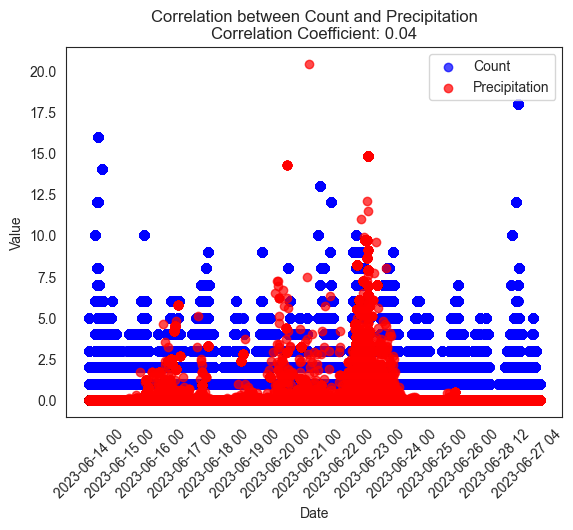

In [16]:
sns.set_style("white")
sns.despine(left=True)

correlation = final_table['count'].corr(final_table['prcp'])

plt.scatter(final_table['date'], final_table['count'],
            label='Count', c='blue', alpha=0.7)
plt.scatter(final_table['date'], final_table['prcp'],
            label='Precipitation', c='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Correlation between Count and Precipitation\nCorrelation Coefficient: {:.2f}'.format(
    average_correlation))
plt.legend()
plt.xticks(rotation=45)

xticklabels = plt.gca().get_xticklabels()
for i, label in enumerate(xticklabels):
    if i % 24 != 0:
        label.set_visible(False)

plt.show()

Again, no real correlation can be seen, but at least this graph shows the three rain events well. It can also be seen that train delays vary with day and night.

## 5. Conclusion 

Unfortunatly, the limited timeframe made it hard to identify a significant correlation and draw a definitive conclusion. I have tried to show what would have been possible with more data and a longer timeframe.

In addition, it has to be considered that there are other causes of the train delayes. Even during the past week with really good weather, delays still occured. Signal failures, technical issues, accidents causing emergency services on the tracks, and staff-related factors, such as illness or waiting for staff from other trains, can all independently contribute to delays. Additionally, delays can propagate, creating a cascading effect.

While the correlation between weather and train delays could not be fully established, it is clear that multiple causes influence the DB train timetables.
